# Capstone - Sentiment Based Product Recommendation System:

- **Problem Statement:**

    'Ebuss' is an e-commerce company. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products. With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders. The ask was to build a model that will improve the recommendations given to the users given their past reviews and ratings.


- **Tasks:**

  1. Data sourcing and sentiment analysis

      i. EDA (Exploratory Data Analysis) & Data Cleaning
      
      ii. Text preprocessing
      
      iii. Feature extraction

      iv. Training text classification model

  2. Building a recommendation system:

      building following types of recommendation systems:

      1. User-based recommendation system
    
      2. Item-based recommendation system
  
  3. Improving the recommendations using the sentiment analysis model

  4. Deploying the end-to-end project with a user interface

## Task1: Data sourcing and sentiment analysis

- Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

from collections import Counter
from imblearn.over_sampling import SMOTE

import pickle

import warnings
warnings.simplefilter("ignore")

In [2]:
# Downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

- Utility API's

In [3]:
# Find Missing Value percentage, and round of the value to 3 decimal values
def get_missing_value_percentage(X):
  percent_missing = round((X.isnull().sum() / X.isnull().count()*100),3).to_frame('missing_percentage').sort_values('missing_percentage',ascending = False)
  return percent_missing

In [4]:
OBJECT_FILE_PATH = "/content/gdrive/MyDrive/Capstone/data/"

#To save objects at intermediate step
def save_object(obj, filename):
    pkl_filename = OBJECT_FILE_PATH + filename + ".pkl"
    with open(pkl_filename, 'wb') as files:
      pickle.dump(obj, files)

### 1.1 EDA &  Data Cleaning

In [5]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
DATA_FILE_LOC = "/content/gdrive/MyDrive/Capstone/sample30.csv"

In [7]:
ebuss_df = pd.read_csv(DATA_FILE_LOC)
ebuss_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


Generating ProfileReport

In [8]:
!pip install ydata-profiling
from ydata_profiling import ProfileReport

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 71.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=12e902aa67a3c058a360170d0dd44ffb9226f9fe3d7c6b72606dfbcac7f25838
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [9]:
profile = ProfileReport(ebuss_df)
profile

Output hidden; open in https://colab.research.google.com to view.

- From the ProfilingReport: Below are the observations:
  - `reviews_userCity`, `reviews_userProvince` has extremely high missing values ( >90%), so these columns will not help much in our analysis and can be dropped.
  - `reviews_didPurchase` has also high (>40%) of misssing values, which can be dropped.
  - `user_sentiment` column which indicates the overall user feedback as Postive, Negative, which is a target column in this case, has highly imbalance with positive classes percentages close to ~88%. So we need to consider handling imbalance problems.
  - `reviews_doRecommend` also has similar observation where there are almost ~94% of the data  contains TRUE values. This column will not add much value to final analysis, and this  can be dropped.

- Note: ProfileReport is used to get a very high level glimpse of the variables, distribution etc.,. Below subsequent steps of data cleaning, preprocessing, feature engineering etc., are done manually.

In [10]:
# shape of Dataset
ebuss_df.shape

(30000, 15)

In [11]:
ebuss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [12]:
# Number of Unique categories
len(ebuss_df['categories'].unique())

270

In [13]:
valuecount = ebuss_df['categories'].value_counts()
valuecount[valuecount > 1000]

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8545
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys                                                                                                                                                                                                                                                                                                                                                                                                   3325
Household Chemicals,Household Cleaners,Bath & 

In [14]:
# Number of Unique users who has written review
len(ebuss_df['reviews_username'].unique())

24915

- out of 30000 records that are present, it has data for 24915 users, and for 270 different categories of data.

In [15]:
# Get the count by username
ebuss_df['reviews_username'].value_counts()

mike                 41
byamazon customer    41
chris                32
lisa                 16
sandy                15
                     ..
nurse32               1
lisa62                1
bigal515              1
mom271                1
kcoopxoxo             1
Name: reviews_username, Length: 24914, dtype: int64

In [16]:
# Calculate missing value percentage
percent_missing = get_missing_value_percentage(ebuss_df)
percent_missing.head(10)

,missing_percentage
reviews_userProvince,99.433
reviews_userCity,93.570
reviews_didPurchase,46.893
reviews_doRecommend,8.567
reviews_title,0.633
manufacturer,0.470
reviews_username,0.210
reviews_date,0.153
user_sentiment,0.003
id,0.000


#### Observation:

- `reviews_userProvince`: This column has > 99% missing values. So its not useful for analysis, and this column can be dropped.
- `reviews_userCity`: This column has > 93% missing values. So its not useful for analysis, and this column can be dropped.
- `reviews_didPurchase`: This column has > 46% missing values. So its not useful for analysis, and this column can be dropped.

In [17]:
columns_to_drop = ['reviews_userProvince','reviews_userCity','reviews_didPurchase']

In [18]:
ebuss_df.drop(columns=columns_to_drop,inplace=True)

In [19]:
ebuss_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [20]:
# Calculate missing value percentage again
percent_missing = get_missing_value_percentage(ebuss_df)
percent_missing.head(10)

,missing_percentage
reviews_doRecommend,8.567
reviews_title,0.633
manufacturer,0.470
reviews_username,0.210
reviews_date,0.153
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000
name,0.000


In [21]:
# Checking for 'reviews_doRecommend' column
ebuss_df['reviews_doRecommend'].value_counts()

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64

In [22]:
# Calculate the % of positive vs negative classes
round(ebuss_df['reviews_doRecommend'].value_counts(normalize=True) * 100,3)

True     94.349
False     5.651
Name: reviews_doRecommend, dtype: float64

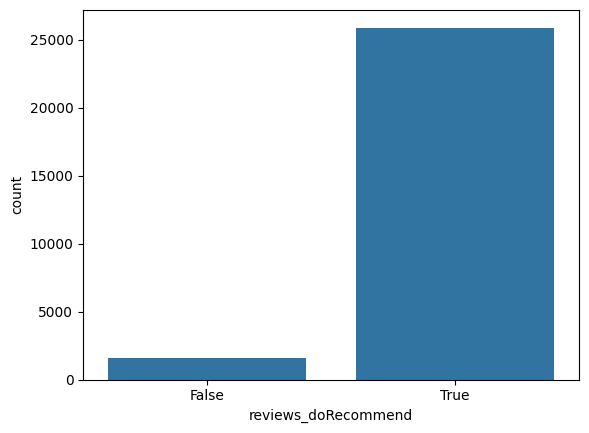

In [23]:
sns.countplot(x='reviews_doRecommend', data = ebuss_df)
plt.show()

#### Observation:

- >94% of the values for `reviews_doRecommend` field is True, and data is skewed in this case. As majority of the values are positive, this will not add much value to final analysis, and this field can be dropped.

In [24]:
ebuss_df.drop(columns=['reviews_doRecommend'],inplace=True)

In [25]:
# Calculate missing value percentage again
percent_missing = get_missing_value_percentage(ebuss_df)
percent_missing.head(5)

,missing_percentage
reviews_title,0.633
manufacturer,0.470
reviews_username,0.210
reviews_date,0.153
user_sentiment,0.003


#### Observation:

- Since `reviews_title` has only ~0.6% of missing values, which shdnt impact the analysis. So dropping those rows.

In [26]:
ebuss_df_clean = ebuss_df.dropna(subset=['reviews_title'])
ebuss_df_clean.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [27]:
# Calculate missing value percentage again
percent_missing = get_missing_value_percentage(ebuss_df_clean)
percent_missing.head(5)

,missing_percentage
manufacturer,0.473
reviews_username,0.208
reviews_date,0.154
user_sentiment,0.003
id,0.000


#### Observation:

- Since `reviews_username` has only ~0.2% of missing values, so for this case, the missing values are imputed as 'others'.

In [28]:
ebuss_df_clean['reviews_username'].fillna('others',inplace=True)

In [29]:
# Re-calculating missing value percentage again
percent_missing = get_missing_value_percentage(ebuss_df_clean)
percent_missing.head(5)

,missing_percentage
manufacturer,0.473
reviews_date,0.154
user_sentiment,0.003
id,0.000
brand,0.000


In [30]:
# Calculate the categories of different manufacturers
round(ebuss_df_clean['manufacturer'].value_counts(normalize=True) * 100,3)

Clorox                                28.801
Test                                  11.204
AmazonUs/CLOO7                         6.872
L'oreal Paris                          4.152
Walt Disney                            3.842
                                       ...  
Herr's                                 0.003
Pacific Foods of Oregon, Inc.          0.003
Unfi                                   0.003
Southern Enterprises                   0.003
Universal Music Group / Cash Money     0.003
Name: manufacturer, Length: 213, dtype: float64

- As there are multiple manufacturers (213), considering the top 95% of manufacturers, and tagging the rest of the manufacturers as others.

In [31]:
# cumulative percentage is calculated for given column
def get_columns_with_cumfreq(df, column_name,threshold):
    df_cat_freq = df[column_name].value_counts()
    df_cat_freq = pd.DataFrame({'column':df_cat_freq.index, 'value':df_cat_freq.values})
    #print(df_cat_freq.head(50))
    df_cat_freq['perc'] = df_cat_freq['value'].cumsum()/df_cat_freq['value'].sum()
    return list(df_cat_freq.loc[df_cat_freq['perc']<=threshold].column)

In [32]:
top_manufacturer_list = get_columns_with_cumfreq(ebuss_df_clean,'manufacturer',0.95)
print(top_manufacturer_list)

['Clorox', 'Test', 'AmazonUs/CLOO7', "L'oreal Paris", 'Walt Disney', "Burt's Bees", 'SONY CORP', 'Twentieth Century Fox', 'P&G', 'Nexxus Beauty Products', 'Summit Entertainment', 'Universal', 'Lundberg Family Farms', 'Clear', 'Hoover', 'Windex', 'Avery Dennison', 'Aveeno Baby', 'Esselte Corporation', 'Tostitos', '1200', 'Frito-Lay', 'TIME WARNER', 'Combe Incorporated', 'UNILEVER', 'Broken Bow', 'Reckitt Benckiser', 'Lions Gate', 'Hormel', 'Coty brands', 'Warner Home Video', 'Pantene Pro-V Hair Care', '20th Century Fox', 'GENERAL MILLS SALES, INC.', 'CUISINART', 'Vaseline', 'Procter & Gamble Company', 'Aussie', 'Bounce', 'GHP Group, Inc.', 'Energizer Personal Care', 'Unilever', 'Nabisco Biscuit Company', 'Caress', 'Hbo Home Video', 'Dr Pepper/Seven Up, Inc', 'Yes To Inc.', 'Generic', 'Axe', 'Tresemme', 'Orajel']


In [33]:
len(top_manufacturer_list)

51

- As top 95% corresponds to 51 manufacturers, tagging other columns as 'others'

In [34]:
# all the levels below 95 percentage are assgined to a single level called others
# get rows for levels which are not present in top_manufacturer_list
ebuss_new_df = ebuss_df_clean[~ebuss_df_clean['manufacturer'].isin(top_manufacturer_list)]
# replace the value of these levels to others
ebuss_new_df['manufacturer'] = "others"
# get rows for levels which are present in list_platform
ebuss_old_df = ebuss_df_clean[ebuss_df_clean['manufacturer'].isin(top_manufacturer_list)]
# concatenate new_df and old_df to get the final dataframe
ebuss_updated_df = pd.concat([ebuss_new_df, ebuss_old_df])

In [35]:
# Re-calculating missing value percentage again
percent_missing = get_missing_value_percentage(ebuss_updated_df)
percent_missing.head(5)

,missing_percentage
reviews_date,0.154
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000


In [36]:
#converting 'reviews_date' to date time object
ebuss_updated_df["reviews_date"] = pd.to_datetime(ebuss_updated_df["reviews_date"], errors='coerce')

In [37]:
ebuss_updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29810 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                29810 non-null  object             
 1   brand             29810 non-null  object             
 2   categories        29810 non-null  object             
 3   manufacturer      29810 non-null  object             
 4   name              29810 non-null  object             
 5   reviews_date      29756 non-null  datetime64[ns, UTC]
 6   reviews_rating    29810 non-null  int64              
 7   reviews_text      29810 non-null  object             
 8   reviews_title     29810 non-null  object             
 9   reviews_username  29810 non-null  object             
 10  user_sentiment    29809 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(9)
memory usage: 2.7+ MB


- As there are < 0.1 % of records where NA values are present for reviews_date column, dropping those rows.

In [38]:
ebuss_updated_df = ebuss_updated_df[~ ebuss_updated_df['reviews_date'].isna()]

In [39]:
# Re-calculating missing value percentage again
percent_missing = get_missing_value_percentage(ebuss_updated_df)
percent_missing.head(5)

,missing_percentage
user_sentiment,0.003
id,0.000
brand,0.000
categories,0.000
manufacturer,0.000


In [40]:
# checking for 'user_sentiment' field
ebuss_updated_df['user_sentiment'].value_counts()

Positive    26419
Negative     3336
Name: user_sentiment, dtype: int64

In [41]:
# Calculate the % of positive vs negative classes
round(ebuss_updated_df['user_sentiment'].value_counts(normalize=True) * 100,3)

Positive    88.788
Negative    11.212
Name: user_sentiment, dtype: float64

- As overall feedback is skewed and is positive, for missing values for 'user_sentiment' column it is being updated as Positive.

#### Note:

- Provided data has clearly class imbalance, as positive class has 88.7%. So we need to ensure class imbalance issue is addressed. [SMOTE technique will be used to address the same during model building].

In [42]:
ebuss_updated_df['user_sentiment'].fillna('Positive', inplace=True)

In [43]:
# Re-calculating missing value percentage again
percent_missing = get_missing_value_percentage(ebuss_updated_df)
percent_missing.head()

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0


- All the null values are addressed.

### 1.2. Text Preprocessing:

In [44]:
# creating a new feature 'user_sentiment_flag'
# 'Positive' sentiments will be marked as "1" and  'Negative' sentiments will be marked as "1"
ebuss_updated_df['user_sentiment_flag'] = ebuss_updated_df['user_sentiment'].apply(lambda x: 1 if x == "Positive" else 0)

In [45]:
# Check the shape of updated df
ebuss_updated_df.shape

(29756, 12)

- Check the review_rating field to understand the distribution

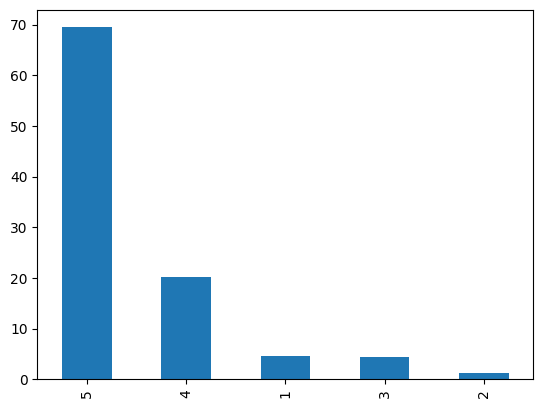

In [46]:
percent_val = 100 * ebuss_updated_df['reviews_rating'].value_counts()/len(ebuss_updated_df)
percent_val.plot.bar()
plt.show()

In [47]:
# Preprocess text fields
def preprocess(document):
  # 1. Change the document to lower case
  document = document.lower()

  # 2. Remove punctuation and words containing numbers
  document = re.sub("[^\sA-z]","",document)

  # 3. Tokenize the words
  words = word_tokenize(document)

  # 4. Remove the stop words
  words = [word for word in words if word not in stopwords.words("english")]

  # 5. Remove words with 0 or 1 letter
  words = [w for w in words if len(w) > 1]

  # 6. join
  document = " ".join(words)
  return(document)


In [48]:
# using spacy
import spacy
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

In [49]:
# Applying Lemmatization
def lemmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [50]:
ebuss_updated_df["reviews_preprocess_text"] = ebuss_updated_df[['reviews_title', 'reviews_text']].agg(' '.join, axis=1).str.lstrip('. ')

In [51]:
#Apply Preprocessing
ebuss_updated_df["reviews_preprocess_text"] = ebuss_updated_df["reviews_preprocess_text"].apply(preprocess)

In [52]:
# Concatenating review title and review text which can be used for further analysis analysis
ebuss_updated_df["reviews_complete_text"] = ebuss_updated_df["reviews_preprocess_text"].apply(lemmatize_text)


In [53]:
ebuss_updated_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,user_sentiment_flag,reviews_preprocess_text,reviews_complete_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",others,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,1,awesome love album good hip hop side current p...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,1,good good flavor review collected part promotion,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor.,Good,dorothy w,Positive,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",others,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,0,disappointed read reviews looking buying one c...,disappoint read review look buy one couple lub...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",others,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,0,irritation husband bought gel us gel caused ir...,irritation husband buy gel us gel cause irrita...


- `reviews_complete_text` field has some null values after lemmatization. Fill all null values same as reviews_text.

In [54]:
ebuss_updated_df.shape

(29756, 14)

In [55]:
ebuss_updated_df['reviews_complete_text'].fillna(ebuss_updated_df['reviews_text'],inplace=True)

In [56]:
save_object(ebuss_updated_df, 'preprocessed-data')

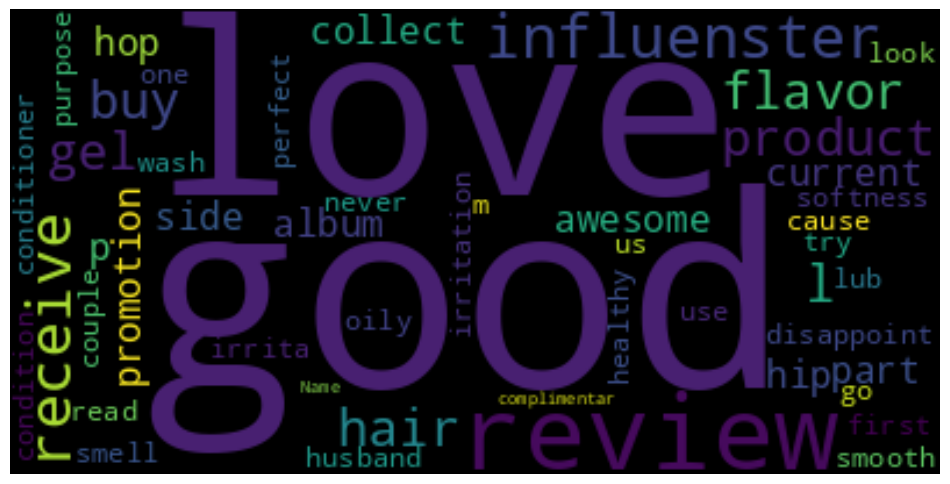

In [57]:
# Create WordCloud to check on Top 50 words
wordcloud = WordCloud(max_words=50, random_state=42)
wordcloud.generate(str(ebuss_updated_df['reviews_complete_text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

- Looks all the wordcloud contains both postive, negative words

In [58]:
words_per_review = ebuss_updated_df['reviews_complete_text'].apply(lambda x: len(x.split(" ")))
print('Average words per Review:', round(words_per_review.mean(),2))

Average words per Review: 19.95


- There are approximately 20 words per review on an average

#### Train Test Split

In [59]:
# Creating TF-IDF vectorizer, for model building
# Considering all unigram, bigram, trigram words
vectorizer = TfidfVectorizer(max_df=0.95,min_df=5,
                             stop_words='english',
                             tokenizer= word_tokenize,
                             ngram_range=(1,3))

### 1.3. Feature Extraction

In [60]:
# Fitting the TF-IDF vectorizer on the training set
X_tfidf = vectorizer.fit_transform(ebuss_updated_df['reviews_complete_text'])
y = ebuss_updated_df['user_sentiment_flag']

In [61]:
# Save Vectorizer Object
save_object(vectorizer, 'tfidf-vectorizer')

In [62]:
# check shape after vectorization
print(X_tfidf.shape)
print(y.shape)

(29756, 21250)
(29756,)


- To address class imbalance problem, applying SMOTE Technique

In [63]:
# splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state=42, test_size=0.2)

In [64]:
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)

X_train shape = (23804, 21250)
X_test shape = (5952, 21250)
y_train shape = (23804,)
y_test shape = (5952,)


### 1.4. Training Classification Model

### Model Building

In [65]:
class ModelFactory:
  def __init__(self,model, model_name, X_train,y_train,X_test,y_test):
    self.model = model
    self.model_name = model_name
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.train_metrics = []
    self.test_metrics = []

  def train(self):
    self.model.fit(self.X_train,self.y_train)
    return self.model.predict(self.X_train)

  def test(self):
    return self.model.predict(self.X_test)

  # This API is added for model load cases
  def set_test_data(self,test_data):
    self.X_test = test_data

  def predict(self):
    return self.model.predict(self.X_test)


  def evaluate_metrics_train(self,y_pred):
    accuracy = round(accuracy_score(self.y_train, y_pred),2)
    precision = round(precision_score(self.y_train,y_pred),2)
    recall = round(recall_score(self.y_train,y_pred),2)
    f1 = round(f1_score(self.y_train,y_pred),2)
    auc_score = round(roc_auc_score(self.y_train,y_pred),2)
    self.train_metrics.append(accuracy)
    self.train_metrics.append(precision)
    self.train_metrics.append(recall)
    self.train_metrics.append(f1)
    self.train_metrics.append(auc_score)

    print("Train Data Metrics - ", self.model_name)
    print("="*20)
    print("Accuracy:", self.train_metrics[0])
    print("Precision:", self.train_metrics[1])
    print("Recall:", self.train_metrics[2])
    print("F1 Score:", self.train_metrics[3])
    print("AUC Score:", self.train_metrics[4])

    self.get_confusion_matrix_train(y_pred)
    return


  def evaluate_metrics_test(self,y_pred):
    accuracy = round(accuracy_score(self.y_test, y_pred),2)
    precision = round(precision_score(self.y_test,y_pred),2)
    recall = round(recall_score(self.y_test,y_pred),2)
    f1 = round(f1_score(self.y_test,y_pred),2)
    auc_score = round(roc_auc_score(self.y_test,y_pred),2)
    self.test_metrics.append(accuracy)
    self.test_metrics.append(precision)
    self.test_metrics.append(recall)
    self.test_metrics.append(f1)
    self.test_metrics.append(auc_score)

    print("Test Data Metrics - ", self.model_name)
    print("="*20)
    print("Accuracy:", self.test_metrics[0])
    print("Precision:", self.test_metrics[1])
    print("Recall:", self.test_metrics[2])
    print("F1 Score:", self.test_metrics[3])
    print("AUC Score:", self.test_metrics[4])

    self.get_confusion_matrix_test(y_pred)
    return


  def get_confusion_matrix_train(self, y_pred):
    confusion_mat = confusion_matrix(self.y_train, y_pred)
    print("="*30)
    self.plot_confusion_matrix(confusion_mat,[0,1])
    return


  def get_confusion_matrix_test(self, y_pred):
    confusion_mat = confusion_matrix(self.y_test, y_pred)
    print("="*30)
    self.plot_confusion_matrix(confusion_mat,[0,1])
    return

  def plot_confusion_matrix(self, data, labels):
      sns.set(color_codes=True)
      plt.title("Confusion Matrix")
      ax = sns.heatmap(data, annot=True, cmap="Blues", fmt=".1f")
      ax.set_xticklabels(labels)
      ax.set_yticklabels(labels)
      ax.set(ylabel="True Values", xlabel="Predicted Values")
      plt.show()
      return

  def get_train_metrics(self):
    return self.train_metrics


  def get_test_metrics(self):
    return self.test_metrics



In [66]:
# Saving the model using pickle
import datetime
MODEL_FILE_PATH = "/content/gdrive/MyDrive/Capstone/models/"

In [67]:
# API to Save Model
def save_model(model_name, model_obj):
  pkl_filename = MODEL_FILE_PATH + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".pkl"
  with open(pkl_filename, 'wb') as files:
    pickle.dump(model_obj, files)

#### Model 1: Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
# Logistic Regression Model
lr = LogisticRegression(random_state=42)
lr_obj = ModelFactory(lr, "Logistic Regression", X_train, y_train, X_test, y_test)

Train Data Metrics -  Logistic Regression
Accuracy: 0.91
Precision: 0.91
Recall: 1.0
F1 Score: 0.95
AUC Score: 0.63


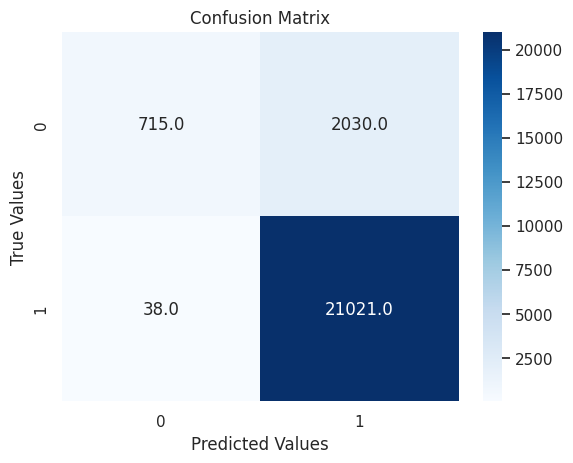

In [70]:
# Train
y_train_pred = lr_obj.train()
lr_obj.evaluate_metrics_train(y_train_pred)

Test Data Metrics -  Logistic Regression
Accuracy: 0.91
Precision: 0.91
Recall: 0.99
F1 Score: 0.95
AUC Score: 0.58


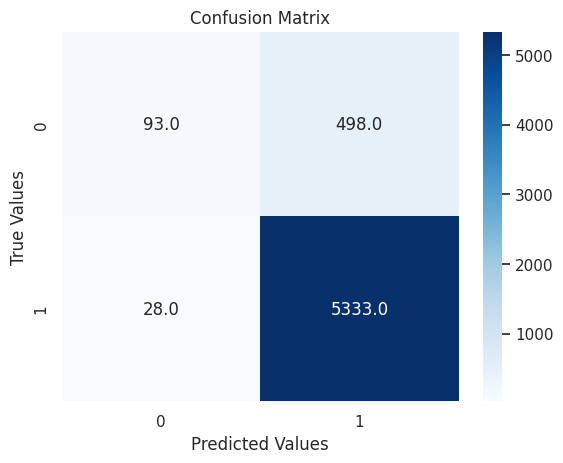

In [71]:
# Test
y_test_pred = lr_obj.test()
lr_obj.evaluate_metrics_test(y_test_pred)

In [72]:
# Saving the model using pickle
save_model("logit",lr_obj)

In [73]:
count = Counter(y_train)
print('Before Applying SMOTE:',count)

sm = SMOTE(random_state = 42)

# transform the dataset
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train.ravel())

count = Counter(y_train_sm)
print('After Applying SMOTE:',count)

Before Applying SMOTE: Counter({1: 21059, 0: 2745})
After Applying SMOTE: Counter({1: 21059, 0: 21059})


#### Model 2: Logistic Regression with Class Balancing (SMOTE Technique)

- In this case we are applying LR with class wight as balances, and max iterations as 100

In [74]:
# Logistic Regression Model with SMOTE
%time
lr_smote = LogisticRegression(random_state=42, class_weight="balanced", max_iter=100)
lr_smote_obj = ModelFactory(lr_smote, "Logistic Regression with SMOTE",
                            X_train_sm, y_train_sm, X_test, y_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


Train Data Metrics -  Logistic Regression with SMOTE
Accuracy: 0.95
Precision: 0.98
Recall: 0.93
F1 Score: 0.95
AUC Score: 0.95


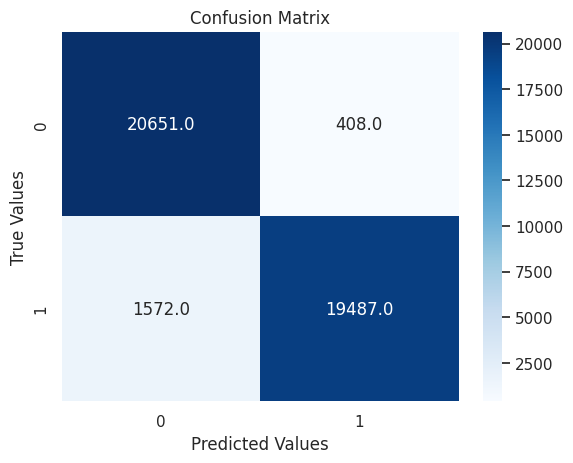

In [75]:
# Train
y_train_pred = lr_smote_obj.train()
lr_smote_obj.evaluate_metrics_train(y_train_pred)

Test Data Metrics -  Logistic Regression with SMOTE
Accuracy: 0.88
Precision: 0.97
Recall: 0.89
F1 Score: 0.93
AUC Score: 0.82


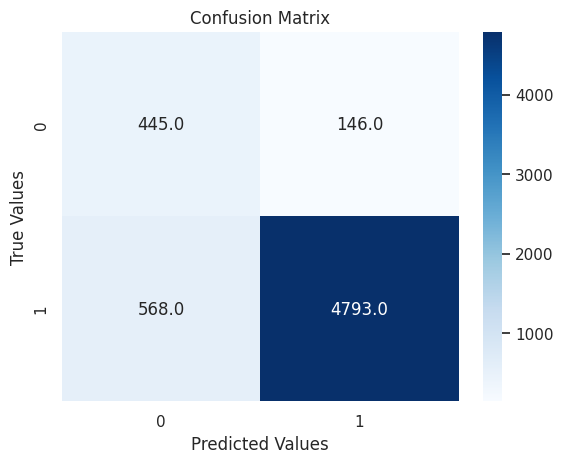

In [76]:
# Test
y_test_pred = lr_smote_obj.test()
lr_smote_obj.evaluate_metrics_test(y_test_pred)

In [77]:
# Saving the model using pickle
save_model("logit_sm",lr_smote_obj)

#### Model 3: Naive Bayes

In [78]:
# training the MultinomialNB model
from sklearn.naive_bayes import MultinomialNB

In [79]:
# MultiNomial NB Object
mnb = MultinomialNB()
mnb_obj = ModelFactory(mnb, "Multinomial NB", X_train_sm, y_train_sm, X_test, y_test)

Train Data Metrics -  Multinomial NB
Accuracy: 0.92
Precision: 0.96
Recall: 0.87
F1 Score: 0.91
AUC Score: 0.92


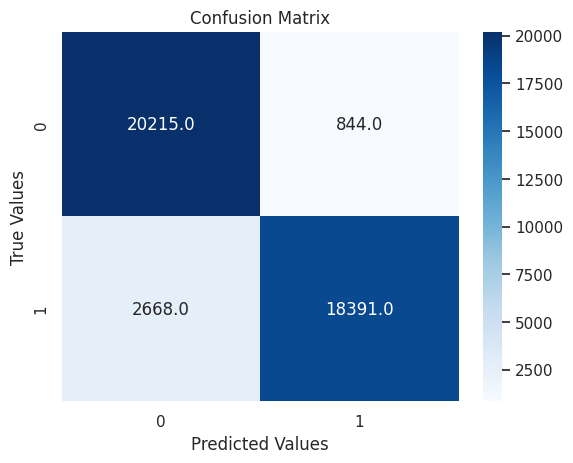

In [80]:
# Train
y_train_pred = mnb_obj.train()
mnb_obj.evaluate_metrics_train(y_train_pred)

Test Data Metrics -  Multinomial NB
Accuracy: 0.83
Precision: 0.96
Recall: 0.85
F1 Score: 0.9
AUC Score: 0.76


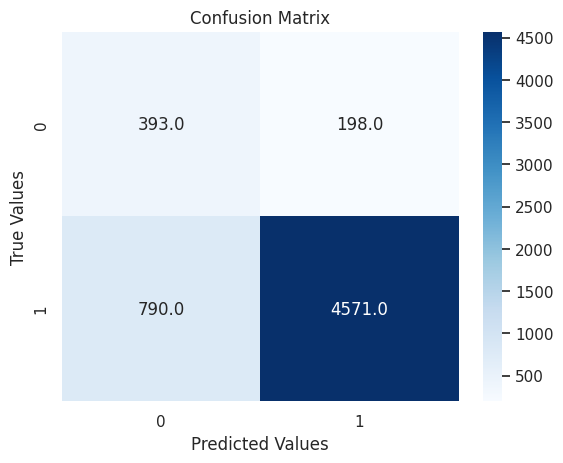

In [81]:
# Test
y_test_pred = mnb_obj.test()
mnb_obj.evaluate_metrics_test(y_test_pred)

In [82]:
# Saving the model using pickle
save_model("mnb",mnb_obj)

#### Model 4: XGBoost

In [83]:
import xgboost as xgb

In [84]:
# XGBoost Object
xgb_classifier = xgb.XGBClassifier(random_state=42, n_jobs=-1)
xgb_obj = ModelFactory(xgb_classifier, "XGBoost", X_train_sm, y_train_sm, X_test, y_test)

Train Data Metrics -  XGBoost
Accuracy: 0.94
Precision: 0.94
Recall: 0.95
F1 Score: 0.94
AUC Score: 0.94


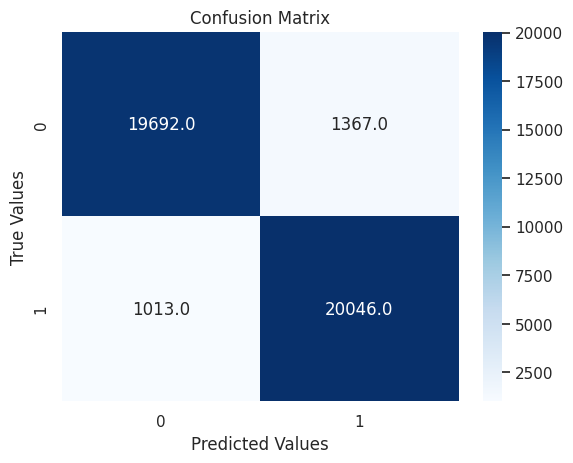

In [85]:
# Train
y_train_pred = xgb_obj.train()
xgb_obj.evaluate_metrics_train(y_train_pred)

Test Data Metrics -  XGBoost
Accuracy: 0.89
Precision: 0.95
Recall: 0.92
F1 Score: 0.94
AUC Score: 0.75


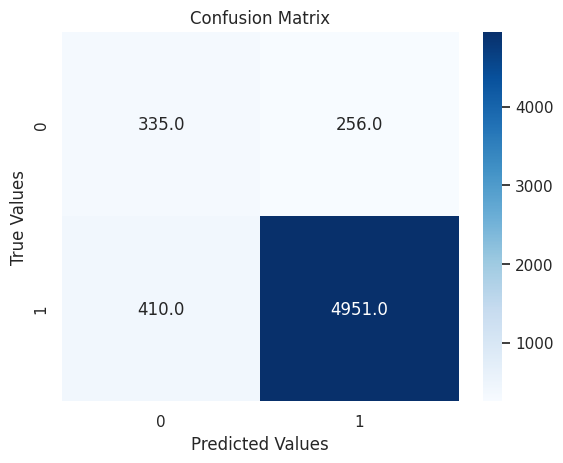

In [86]:
# Test
y_test_pred = xgb_obj.test()
xgb_obj.evaluate_metrics_test(y_test_pred)

In [87]:
# Saving the model using pickle
save_model("xgb",xgb_obj)

- All the parameters looks fine where train, test score looks relatively similar, except for the AUC_ROC score of Train vs Test. So trying with hyper parameter tuning

#### Model 5: XGBoost with HyperParameter Tuning

In [88]:
param_grid_xgb={'learning_rate': [0.001, 0.01,0.1], 'max_depth': [5, 10],
                         'n_estimators': [1, 3]}
xgb_hp_tuned = GridSearchCV(cv=5, estimator=xgb.XGBClassifier(random_state=42, n_jobs=-1),
                            param_grid=param_grid_xgb, verbose=1)
xgb_hp_tuned_obj = ModelFactory(xgb_hp_tuned, "XGBoost HP Tuned", X_train_sm, y_train_sm, X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train Data Metrics -  XGBoost HP Tuned
Accuracy: 0.82
Precision: 0.82
Recall: 0.81
F1 Score: 0.82
AUC Score: 0.82


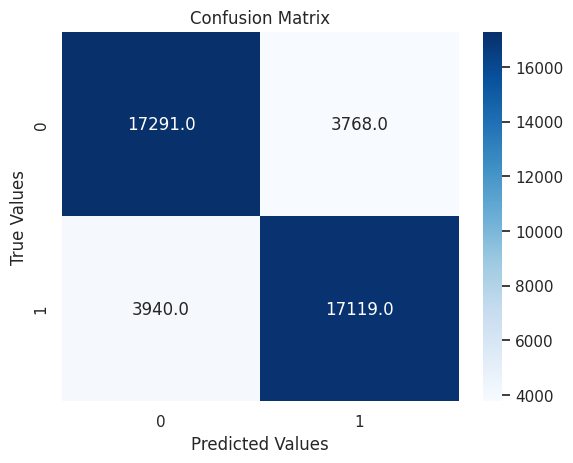

CPU times: user 3min 32s, sys: 47.2 s, total: 4min 19s
Wall time: 4min 21s


In [89]:
# Train
%%time
y_train_pred = xgb_hp_tuned_obj.train()
xgb_hp_tuned_obj.evaluate_metrics_train(y_train_pred)

Test Data Metrics -  XGBoost HP Tuned
Accuracy: 0.78
Precision: 0.95
Recall: 0.8
F1 Score: 0.87
AUC Score: 0.71


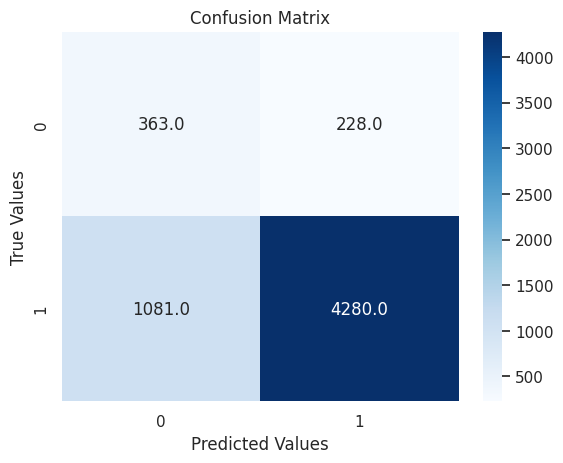

CPU times: user 342 ms, sys: 114 ms, total: 456 ms
Wall time: 340 ms


In [90]:
# Test
%%time
y_test_pred = xgb_hp_tuned_obj.test()
xgb_hp_tuned_obj.evaluate_metrics_test(y_test_pred)

In [91]:
# Saving the model using pickle
save_model("xgb_hp",xgb_hp_tuned_obj)

#### Model 6: Random Forest

In [92]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

In [93]:
# RandomForest Classifier
rf_classifer = RandomForestClassifier(random_state=42,n_jobs=-1)
rf_obj = ModelFactory(rf_classifer, "RandomForest", X_train_sm, y_train_sm, X_test, y_test)

Train Data Metrics -  RandomForest
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC Score: 1.0


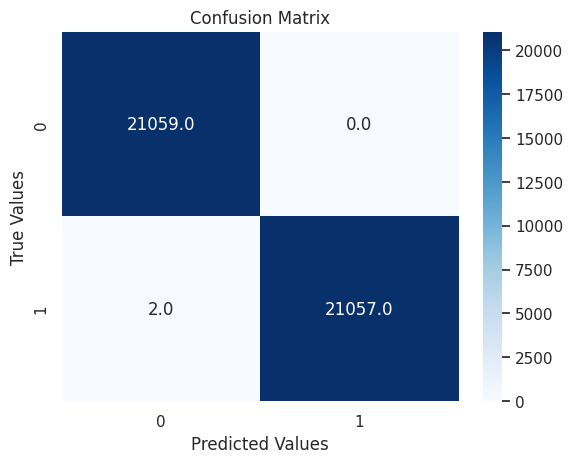

In [94]:
# Train
y_train_pred = rf_obj.train()
rf_obj.evaluate_metrics_train(y_train_pred)

Test Data Metrics -  RandomForest
Accuracy: 0.91
Precision: 0.94
Recall: 0.97
F1 Score: 0.95
AUC Score: 0.69


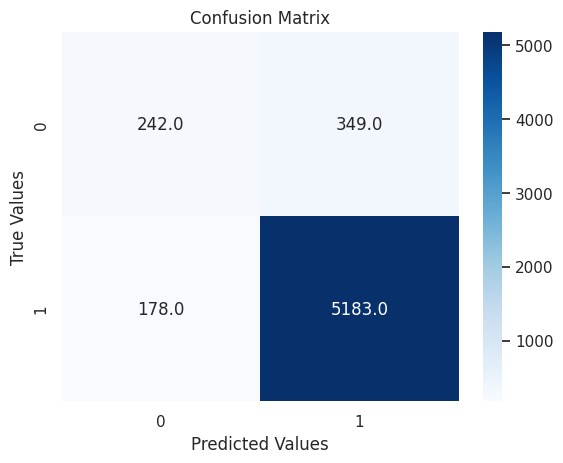

In [95]:
# Test
y_test_pred = rf_obj.test()
rf_obj.evaluate_metrics_test(y_test_pred)

In [96]:
# Saving the model using pickle
save_model("rf",rf_obj)

- RandomForest is clearly overfitting, where all train parameters are 1. So trying with hyper parameter tuning.

#### Model 7: Random Forest with Hyperparameter Tuning

In [97]:
#Tuning the below parameters
# COnsidering the
param_grid_rf = {'max_depth': [2, 3, 5, 10],
                 'min_samples_leaf': [5, 10, 20],
                  'n_estimators': [10, 25, 50, 100]},

In [98]:
rf_hp_tuned = GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42,n_jobs=-1),
                            param_grid=param_grid_rf, verbose=1)
rf_hp_tuned_obj = ModelFactory(rf_hp_tuned, "RandomForest HP Tuned", X_train_sm, y_train_sm, X_test, y_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Train Data Metrics -  RandomForest HP Tuned
Accuracy: 0.81
Precision: 0.76
Recall: 0.89
F1 Score: 0.82
AUC Score: 0.81


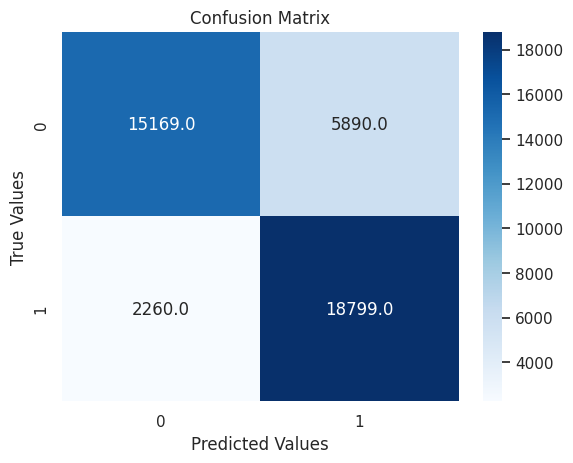

In [99]:
# Train
y_train_pred = rf_hp_tuned_obj.train()
rf_hp_tuned_obj.evaluate_metrics_train(y_train_pred)

Test Data Metrics -  RandomForest HP Tuned
Accuracy: 0.85
Precision: 0.94
Recall: 0.89
F1 Score: 0.91
AUC Score: 0.67


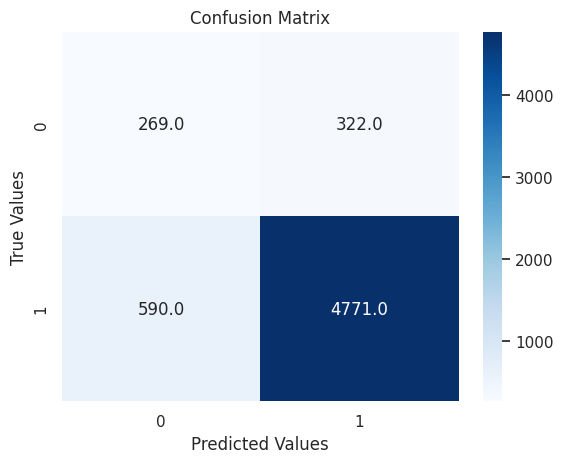

In [100]:
# Test
y_test_pred = rf_hp_tuned_obj.test()
rf_hp_tuned_obj.evaluate_metrics_test(y_test_pred)

In [101]:
# Saving the model using pickle
save_model("rf_hp",rf_obj)

In [102]:
# Creating a table which contain all the metrics
column_names = ['Metric', 'LR Train', 'LR Test','LR SM Train', 'LR SM Test',
                'MNB Train','MNB Test', 'XGB Train', 'XGB Test',
                'XGB HP Train', 'XGB HP Test', 'RF Train', 'RF Test', 'RF HP Train', 'RF HP Test']

metrics_summary = {'Metric': ['Accuracy','Precision','Recall', 'F1 Score','AUC Score'],
        'LR Train': lr_obj.get_train_metrics(),
        'LR Test': lr_obj.get_test_metrics(),
        'LR SM Train': lr_smote_obj.get_train_metrics(),
        'LR SM Test': lr_smote_obj.get_test_metrics(),
        'MNB Train': mnb_obj.get_train_metrics(),
        'MNB Test': mnb_obj.get_test_metrics(),
        'XGB Train': xgb_obj.get_train_metrics(),
        'XGB Test': xgb_obj.get_test_metrics(),
        'XGB HP Train': xgb_hp_tuned_obj.get_train_metrics(),
        'XGB HP Test': xgb_hp_tuned_obj.get_test_metrics(),
        'RF Train': rf_obj.get_train_metrics(),
        'RF Test': rf_obj.get_test_metrics(),
        'RF HP Train': rf_hp_tuned_obj.get_train_metrics(),
        'RF HP Test': rf_hp_tuned_obj.get_test_metrics(),
        }

metrics_df = pd.DataFrame(metrics_summary, columns = column_names)
metrics_df

,Metric,LR Train,LR Test,LR SM Train,LR SM Test,MNB Train,MNB Test,XGB Train,XGB Test,XGB HP Train,XGB HP Test,RF Train,RF Test,RF HP Train,RF HP Test
0,Accuracy,0.91,0.91,0.95,0.88,0.92,0.83,0.94,0.89,0.82,0.78,1.0,0.91,0.81,0.85
1,Precision,0.91,0.91,0.98,0.97,0.96,0.96,0.94,0.95,0.82,0.95,1.0,0.94,0.76,0.94
2,Recall,1.00,0.99,0.93,0.89,0.87,0.85,0.95,0.92,0.81,0.80,1.0,0.97,0.89,0.89
3,F1 Score,0.95,0.95,0.95,0.93,0.91,0.90,0.94,0.94,0.82,0.87,1.0,0.95,0.82,0.91
4,AUC Score,0.63,0.58,0.95,0.82,0.92,0.76,0.94,0.75,0.82,0.71,1.0,0.69,0.81,0.67


- As per the above validation for above metrics, it looks the results of Logistic Regression with SMOTE (addressing class imbalance issues)  performs much better that other models for both train, test data comparing  all the metrics. Hence Logistic Regression with SMOTE technique is chosen.

## Task 2: Building Recommendation System

- As part of this 2 recommendation systems, are being built.
  - User-based Recommendation System
  - Item-based Recommendation System

### 2.1 User-based Recommendation System

In [103]:
recommend_df = pd.read_csv(DATA_FILE_LOC)
recommend_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


- For recommendation system only fields related to user, reviews are needed. So selectcing below columns to build the same.
  - `id`
  - `name`
  - `reviews_rating`
  - `reviews_username`

In [104]:
recommend_df_columns = ['id','name','reviews_rating','reviews_username']

In [105]:
recommend_df = recommend_df[recommend_df_columns]

In [106]:
recommend_df.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


In [107]:
recommend_df.shape

(30000, 4)

- Handling NULL Values

In [108]:
get_missing_value_percentage(recommend_df)

,missing_percentage
reviews_username,0.21
id,0.00
name,0.00
reviews_rating,0.00


- reviews_username columns  alone has very small (0.21%) missing values. Those rows are being droopped, to ensure the recommendation is done for the known user list.

In [109]:
recommend_df = recommend_df[~recommend_df['reviews_username'].isna()]

In [110]:
recommend_df.shape

(29937, 4)

In [111]:
get_missing_value_percentage(recommend_df)

,missing_percentage
id,0.0
name,0.0
reviews_rating,0.0
reviews_username,0.0


Dividing Data into Train Test Split

In [112]:
train, test = train_test_split(recommend_df, test_size=0.30, random_state=30)

In [113]:
print(train.shape)
print(test.shape)

(20955, 4)
(8982, 4)


In [114]:
# Pivot the train ratings dataset into matrix format in which columns are products and the rows are usernames.
df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
df_pivot.shape

(18249, 256)

- Creating dummy train & dummy test dataset:

    These dataset will be used for prediction:

  - Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.
  - Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [116]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [117]:
# The products not rated by user is marked as 1 for prediction.
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [118]:
# Convert the dummy train dataset into matrix format
dummy_train = dummy_train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(1)
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**`Cosine Similarity`**

Cosine Similarity is a measurement that quantifies the similarity between two vectors. In this case it is `reviews_rating` column.




**`Adjusted Cosine`**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

#### User Similarity Matrix

#### Using adjusted Cosine

- Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [119]:
# Create Pivot the train ratings data into matrix
# In this case columns are Products and the rows are usernames.
df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [120]:
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Normalising the rating of the movie for each user around 0 mean

In [121]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [122]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Finding cosine similarity

In [123]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [124]:
user_correlation.shape

(18249, 18249)

#### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [125]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [126]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [127]:
user_predicted_ratings.shape

(18249, 256)

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [128]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
# Save User Final Rating Object
save_object(user_final_rating, 'user_final_rating')

In [130]:
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
#Select Some random user input from dataset
user_input = "joshua"

In [132]:
# Top 20  recommendations for a given user
user_top20 = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_spec_user_top20_reco = pd.DataFrame({'Id': user_top20.index, 'similarity_score' : user_top20})
df_spec_user_top20_reco.reset_index(drop=True, inplace=True)
df_spec_user_top20_reco

,Id,similarity_score
0,AVpe59io1cnluZ0-ZgDU,5.962041
1,AVpfRTh1ilAPnD_xYic2,5.765589
2,AVpfPaoqLJeJML435Xk9,5.665967
3,AVpf3VOfilAPnD_xjpun,5.260096
4,AVpf385g1cnluZ0-s0_t,4.435922
5,AVpe41TqilAPnD_xQH3d,4.240089
6,AVpf5olc1cnluZ0-tPrO,4.231610
7,AVpf0eb2LJeJML43EVSt,3.511053
8,AVpf5Z1zLJeJML43FpB-,3.388860
9,AVpfDA6wilAPnD_xTxdg,2.766993


- Top 20 products user likely going to purchase based on user-user based recommendation

In [133]:
top20_user_rec = pd.merge(recommend_df, df_spec_user_top20_reco,
                          left_on='id',right_on='Id', how = 'inner')[['Id', 'name', 'similarity_score']].drop_duplicates()
top20_user_rec.reset_index(drop=True, inplace=True)
top20_user_rec.sort_values(by='similarity_score', ascending=False)

,Id,name,similarity_score
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,5.962041
17,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,5.765589
12,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5.665967
5,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5.260096
4,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",4.435922
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.240089
7,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,4.231610
3,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),3.511053
8,AVpf5Z1zLJeJML43FpB-,"Lysol Concentrate Deodorizing Cleaner, Origina...",3.388860
9,AVpfDA6wilAPnD_xTxdg,Head & Shoulders Dandruff Shampoo Ocean Lift 2...,2.766993


#### Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [134]:
# Find out the common users of test and train dataset.
common = test[test['reviews_username'].isin(train['reviews_username'])]

In [135]:
common.shape

(2023, 4)

In [136]:
common.head()

,id,name,reviews_rating,reviews_username
25840,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,great
28741,AVpfUJu_ilAPnD_xZdDr,Chobani174 Strawberry On The Bottom Non-Fat Gr...,5,grammy
19507,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,robbiesgirl26
18638,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,4,jend5
3460,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Condi...,5,hollziejozie


In [137]:
# convert into the username-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [138]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [139]:
user_correlation_df

,0,1,2,3,4,5,6,7,8,9,...,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248
userId,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
list_name = common['reviews_username'].tolist()
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [142]:
user_correlation_df_1.shape

(1698, 18249)

In [143]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [144]:
user_correlation_df_3 = user_correlation_df_2.T

In [145]:
user_correlation_df_3

,00sab00,1234,1234567,1234asdf,143st,1943,23jen,37f5p,4djs,7.87E+11,...,yohnie1,yucky111,yummy,yvonne,zach,zburt5,zebras,zippy,zmom,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zburt5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zebras,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zippy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
# Get common user predicted ratings
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [147]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [148]:
#Check the shape of dummy test
dummy_test.shape

(1698, 131)

In [149]:
# Get predicted ratings for common users of train, test
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [150]:
common_user_predicted_ratings.head(2)

id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YtGjdglJLPUi8IOfJ,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [151]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

# Applying MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [152]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [153]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

- RMSE for user recommendation system

In [154]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.5934574223730515


### 2.2 Item Based Recommendation System

#### Using Item similarity

#### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie.

In [155]:
df_pivot = train.pivot_table(index='reviews_username', columns='id',values='reviews_rating').T
df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,11111111aaaaaaaaaaaaaaaaa,...,zoso60,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Normalising the movie rating for each movie for using the Adujsted Cosine

In [156]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [157]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,11111111aaaaaaaaaaaaaaaaa,...,zoso60,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zwithanx,zxcsdfd,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Finding the cosine similarity using pairwise distances approach

In [158]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


- Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [159]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction - Item Item

In [160]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00154282, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00133082, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00133082, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [161]:
item_predicted_ratings.shape

(18249, 256)

In [162]:
dummy_train.shape

(18249, 256)

#### Filtering the rating only for the products not rated by the user for recommendation

In [163]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.021461,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
00sab00,0.0,0.0,0.0,0.003511,0.0,0.0,0.0,0.0,0.000000,0.007049,...,0.004595,0.0,0.0,0.0,0.0,0.0,0.01992,0.000000,0.0,0.0
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003278,0.004477,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.001543,0.0,0.0
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.005463,0.007462,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.002571,0.0,0.0
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.004370,0.005970,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.002057,0.0,0.0


In [164]:
# Take a sample username as input.
user_input = 'joshua'

In [165]:
top20_item = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_spec_item_top20_reco = pd.DataFrame({'Id': top20_item.index, 'similarity_score' : top20_item})
df_spec_item_top20_reco.reset_index(drop=True, inplace=True)
df_spec_item_top20_reco

,Id,similarity_score
0,AVpf5olc1cnluZ0-tPrO,0.076479
1,AVpf0pfrilAPnD_xi6s_,0.053809
2,AVpfQtEm1cnluZ0-hUpe,0.051031
3,AVpfkQkcLJeJML43_kEC,0.048572
4,AVpfr5cb1cnluZ0-pZFp,0.046879
5,AVpe_dxlilAPnD_xSiHI,0.045098
6,AVpf0thK1cnluZ0-r8vR,0.033095
7,AV1Ys0kTvKc47QAVgx1C,0.028652
8,AVpe59io1cnluZ0-ZgDU,0.024548
9,AVpe8xjUilAPnD_xRkxC,0.022484


Finding the Top 20 products that a user is likely to purchase based on the item-item based recommendation

In [166]:
top20_item_reco = pd.merge(recommend_df, df_spec_item_top20_reco,
                           left_on='id',right_on='Id', how = 'inner')[['Id', 'name', 'similarity_score']].drop_duplicates()
top20_item_reco.reset_index(drop=True, inplace=True)
top20_item_reco.sort_values(by='similarity_score', ascending=False)

,Id,name,similarity_score
10,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,0.076479
6,AVpf0pfrilAPnD_xi6s_,Nearly Natural 5.5' Bamboo W/decorative Planter,0.053809
16,AVpfQtEm1cnluZ0-hUpe,Jolly Time Select Premium Yellow Pop Corn,0.051031
12,AVpfkQkcLJeJML43_kEC,Cococare 100% Natural Castor Oil,0.048572
17,AVpfr5cb1cnluZ0-pZFp,Boraam Sonoma Kitchen Cart With Wire Brush Gra...,0.046879
1,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smooth...",0.045098
7,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.033095
0,AV1Ys0kTvKc47QAVgx1C,Meguiar's Deep Crystal Car Wash 64-Oz.,0.028652
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,0.024548
3,AVpe8xjUilAPnD_xRkxC,The Honest Company Laundry Detergent,0.022484


#### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [167]:
test.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username'], dtype='object')

In [168]:
common =  test[test['id'].isin(train['id'])]
common.shape

(8966, 4)

In [169]:
common.head(4)

,id,name,reviews_rating,reviews_username
25840,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,great
7752,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,4,jules57
21261,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,taurusanaya
13300,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,terri38


In [170]:
common_item_based_matrix =  common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [171]:
common_item_based_matrix.shape

(201, 8348)

In [172]:
item_correlation_df = pd.DataFrame(item_correlation)

In [173]:
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
item_correlation_df['productId'] = df_subtracted.index
item_correlation_df.set_index('productId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
productId,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
list_name = common['id'].tolist()

In [176]:
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [177]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T

In [178]:
item_correlation_df_3.head()

,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,...,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
productId,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00442501, 0.        , 0.00355135, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0030629 , 0.        , 0.        , ..., 0.00053233, 0.00133082,
        0.00106466],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01588196, ..., 0.        , 0.        ,
        0.        ]])

In [180]:
common_item_predicted_ratings.shape

(201, 8348)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train


In [181]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

In [182]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [183]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [184]:
X  = common_item_predicted_ratings.copy()
X = X[X>0]

# Applying MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [185]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [186]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.5479115341332403


- Selecting Best Recommendation Model:

In [187]:
print("RMSE of User Based Recommendation System: ", rmse_user_user)
print("RMSE of Item Based Recommendation System: ", rmse_item_item)

if rmse_user_user < rmse_item_item:
  print("User-User Based Model is  Recommended")
else:
  print("Item-Item Based Model is  Recommended")

RMSE of User Based Recommendation System:  2.5934574223730515
RMSE of Item Based Recommendation System:  3.5479115341332403
User-User Based Model is  Recommended


- On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2.5) as compared to Item-Item based recommendation systm. So User Based Recommendation system is chosen.

## Task 3: Improving the recommendations using the sentiment analysis model

### Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [188]:
ebuss_recommend_df = ebuss_updated_df[['id','name','reviews_complete_text', 'user_sentiment_flag']]

In [189]:
def get_top5_user_recommendations(user):
  if user in user_final_rating.index:
    # get the top 20  recommedation using the user_final_rating
    top20_reco = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
    # get the product recommedation using the orig data used for trained model
    common_top20_reco = ebuss_recommend_df[ebuss_updated_df['id'].isin(top20_reco)]
    # Apply the TFIDF Vectorizer for the given 20 products to convert data in reqd format for modeling
    X =  vectorizer.transform(common_top20_reco['reviews_complete_text'].values.astype(str))

    # Recommended model was LR SMOTE
    # So using the same to predict
    lr_smote_obj.set_test_data(X)
    common_top20_reco['sentiment_pred']= lr_smote_obj.predict()

    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    temp_df = common_top20_reco.groupby(by='name').sum()
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    sent_df = temp_df[['sentiment_pred']]
    sent_df.columns = ['pos_sent_count']
    # Create a column to measure the total sentiment count
    sent_df['total_sent_count'] = common_top20_reco.groupby(by='name')['sentiment_pred'].count()
    # Calculate the positive sentiment percentage
    sent_df['pos_sent_percent'] = np.round(sent_df['pos_sent_count']/sent_df['total_sent_count']*100,2)
    # Return top 5 recommended products to the user
    result = sent_df.sort_values(by='pos_sent_percent', ascending=False)[:5]
    return result
  else:
    print(f"User name {user} doesn't exist")

- Top 5 Recommendations:

 - Find top 5 recommendations for one of the selected users.

In [190]:
# Select one of the user name
input_user_name = "rebecca"

In [191]:
# testing the above fuction using one of the users that's trained on.
get_top5_user_recommendations(input_user_name)

,pos_sent_count,total_sent_count,pos_sent_percent
name,,,
Red (special Edition) (dvdvideo),626,672,93.15
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),619,668,92.66
Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,94,103,91.26
100:Complete First Season (blu-Ray),125,139,89.93
Clorox Disinfecting Bathroom Cleaner,1825,2039,89.50
